In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *
# Add below import (based on Is It A Bird? notebook)
from fastdownload import download_url

In [5]:
# Replaced search_images_bing with DuckDuckGo
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [6]:
# Use function definition from "Is it a bird?" notebook
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))

In [7]:
results = search_images_ddg('grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

200

In [8]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']


In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [11]:
from time import sleep

In [12]:
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    # results = search_images(f'{o} bear')
    download_images(dest, urls=search_images(f'{o} bear'))
    sleep(5)  # Pause between bear_types searches to avoid over-loading server


Searching for 'grizzly bear'
Searching for 'black bear'
Searching for 'teddy bear'


In [13]:
fns = get_image_files(path)
fns

(#242) [Path('bears/grizzly/7f754408-2667-496f-a865-9113f7f5deba.jpg'),Path('bears/grizzly/648227d3-26ab-435d-87e9-37fdf1303236.jpg'),Path('bears/grizzly/07dfce1c-53cf-4c43-b951-adf2010ea9f6.jpg'),Path('bears/grizzly/6d43e404-e774-4cf4-ab4b-9201beaa4f1c.jpg'),Path('bears/grizzly/3a8aed96-f909-41c3-ae11-1d3c887e284c.jpg'),Path('bears/grizzly/4b52777e-3b9f-4c07-8da1-550e74745711.jpg'),Path('bears/grizzly/bbb22338-a417-4896-8177-c82a25560e22.jpg'),Path('bears/grizzly/6bd342e2-883c-4d07-b99f-94b2519e5a29.jpg'),Path('bears/grizzly/56682acf-edec-48e3-8ee5-cca8bb5c4181.jpg'),Path('bears/grizzly/c57f7d26-1bb3-46b8-b0dd-2c6586ef7d5e.jpg')...]

In [14]:
len(fns)

242

In [15]:
failed = verify_images(fns)
failed

(#2) [Path('bears/grizzly/7499f4e8-1db2-4d9d-a0c0-28f15443a261.jpg'),Path('bears/teddy/84880577-bf16-4345-bbd0-d1c9d7ae913a.jpg')]

In [16]:
failed.map(Path.unlink);

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = bears.dataloaders(path)

/opt/conda/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


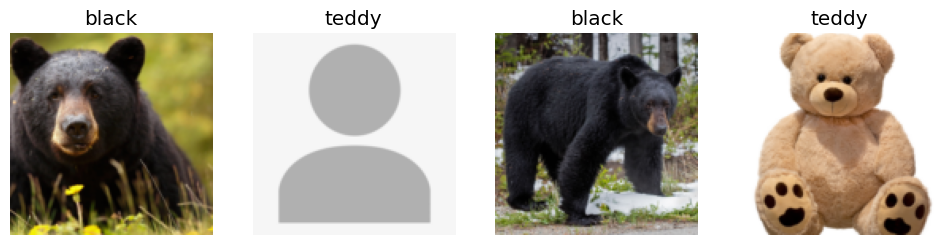

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

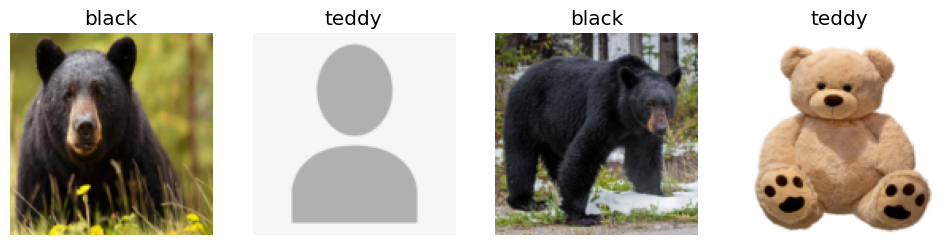

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

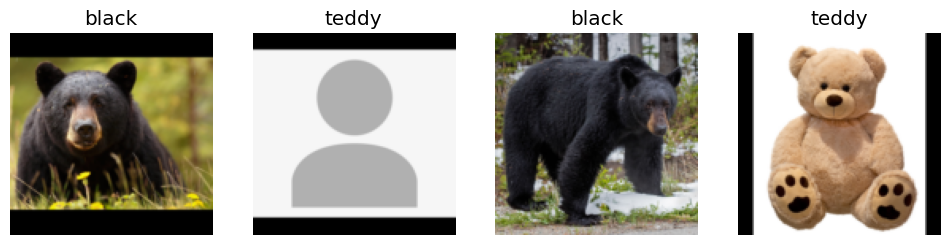

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

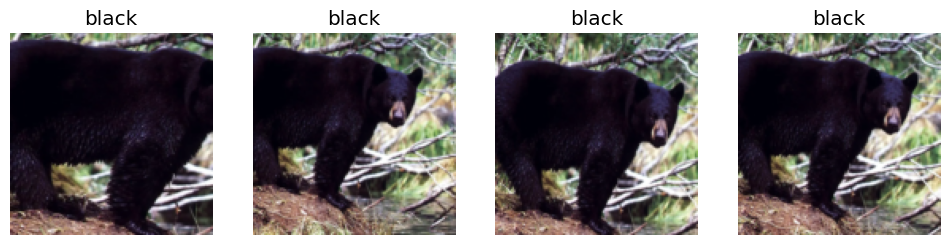

In [21]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

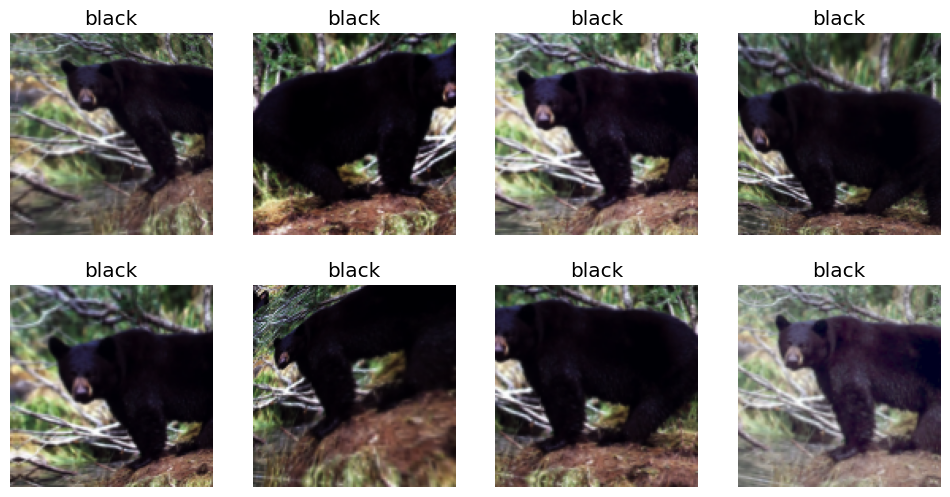

In [22]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


In [18]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.756534,0.574446,0.229167,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.395977,0.220872,0.104167,00:41
1,0.261527,0.052553,0.000000,00:42
2,0.189839,0.036865,0.000000,00:36
3,0.147607,0.032443,0.000000,00:28


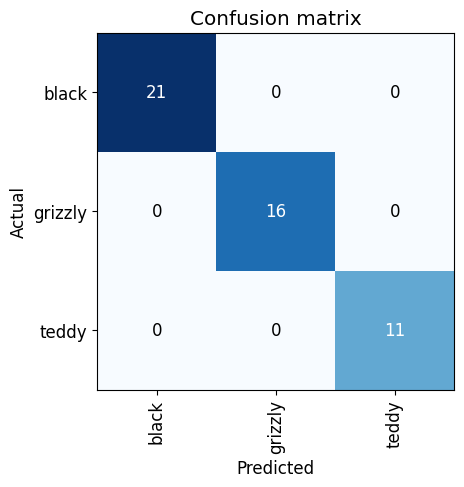

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [21]:
learn.export()

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('images/grizzly.jpg')

/opt/conda/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('grizzly', tensor(1), tensor([5.1146e-04, 9.9946e-01, 2.6557e-05]))

In [26]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [27]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [28]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [29]:
img = PILImage.create(btn_upload.data[-1])

In [30]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [31]:
pred,pred_idx,probs = learn_inf.predict(img)

In [32]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9995')

In [33]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [34]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [35]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [36]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [38]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.6 MB/s eta 0:00:0000:0100:01
Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.5.5 OK
